In [181]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import os

# Setup Seaborn
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Define input directory
input_dir = '/kaggle/input/'

# Load and explore the dataset
sales_df = pd.read_csv(os.path.join(input_dir, 'demand-forecasting-kernels-only/train.csv'))
sales_df['date'] = pd.to_datetime(sales_df['date'])
df = sales_df.set_index(['date', 'store', 'item'])

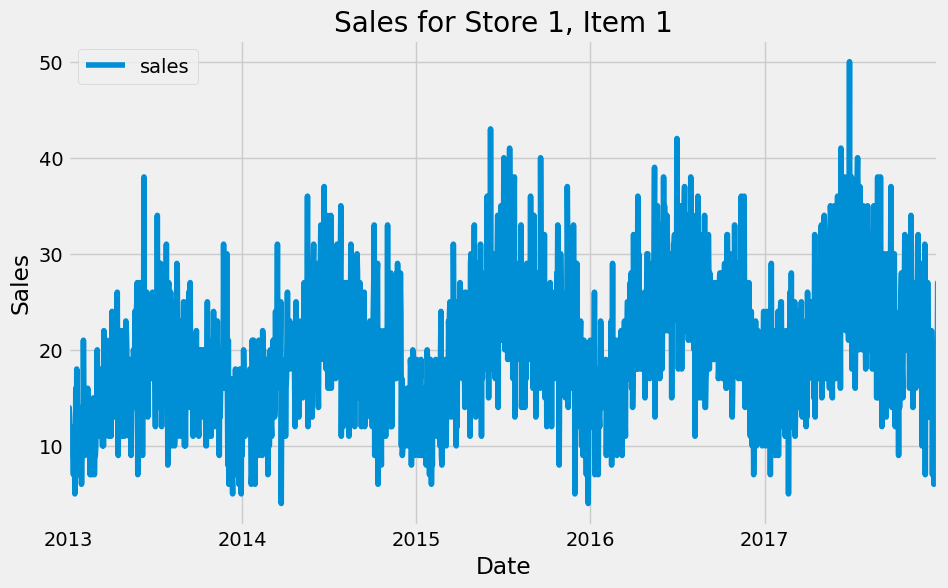

In [182]:
# Visualize sales data for Store 1, Item 1
df.xs((1, 1), level=('store', 'item')).plot(figsize=(10, 6), title='Sales for Store 1, Item 1')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

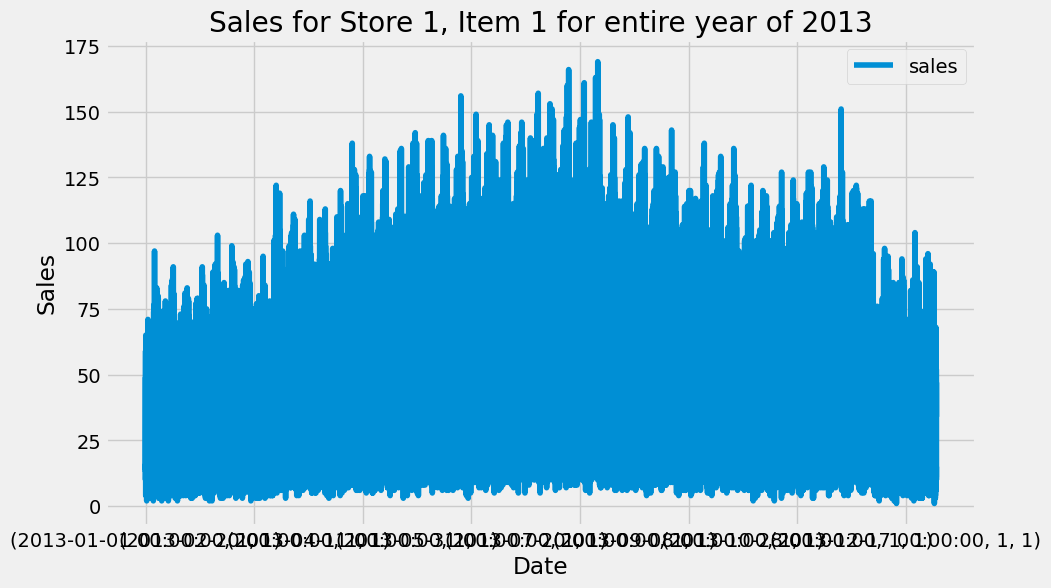

In [183]:
# Plot sales data for Store 1, Item 1 for the year 2013
df = df.sort_index(level=0)
subset_df = df.loc[('2013-01-01',1,1) : ('2013-12-31', 1,1)]
# Plot the sales data
subset_df.plot(figsize = (10,6))

# Add axis labels and title
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales for Store 1, Item 1 for entire year of 2013')
plt.show()

In [184]:
# Define functions for creating time series features
def create_features(df):
    df['dayofweek'] = df.index.get_level_values('date').dayofweek
    df['dayofmonth'] = df.index.get_level_values('date').day
    df['quarter'] = df.index.get_level_values('date').quarter
    df['month'] = df.index.get_level_values('date').month
    df['year'] = df.index.get_level_values('date').year
    df['dayofyear'] = df.index.get_level_values('date').dayofyear
    return df

# Apply feature creation function to the dataset
df = create_features(df)
df.head()

sales  dayofweek  dayofmonth  quarter  month  year  \
date       store item                                                       
2013-01-01 1     1        13          1           1        1      1  2013   
                 2        33          1           1        1      1  2013   
                 3        15          1           1        1      1  2013   
                 4        10          1           1        1      1  2013   
                 5        11          1           1        1      1  2013   

                       dayofyear  
date       store item             
2013-01-01 1     1             1  
                 2             1  
                 3             1  
                 4             1  
                 5             1

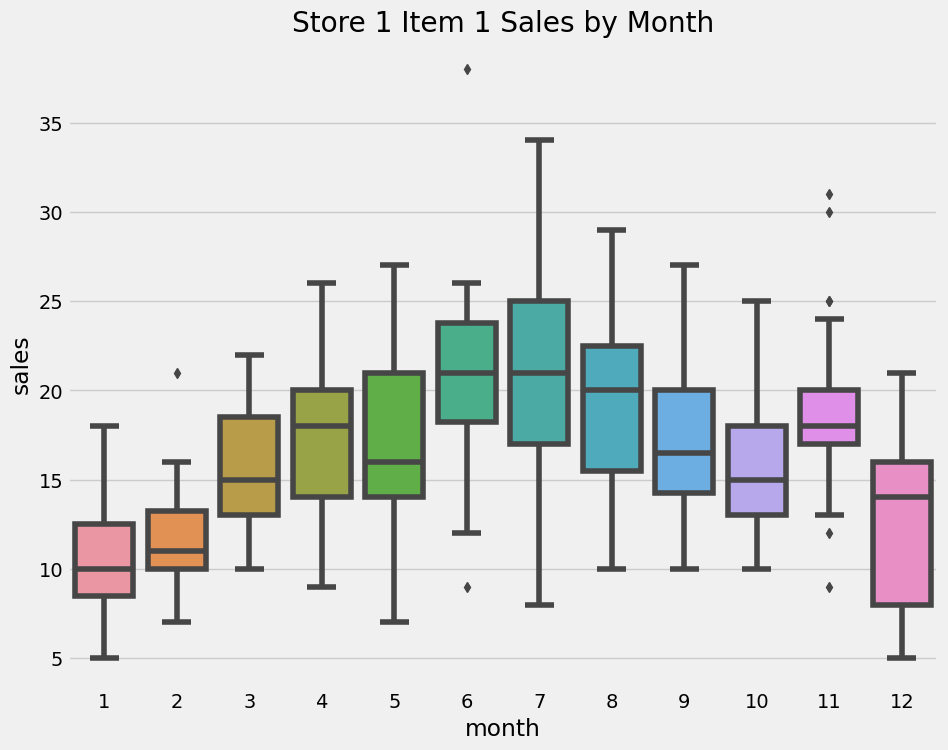

In [185]:
# Boxplot of Store 1, Item 1 Sales by Month for the Year 2013
fig, ax = plt.subplots(figsize=(10, 8))
subset_df = df.loc[('2013', 1, 1), :]
sns.boxplot(data=subset_df, x='month', y='sales')
ax.set_title('Store 1 Item 1 Sales by Month')
plt.show()

In [186]:
# Reload the original sales data into the DataFrame
df = sales_df

# Define a function to create time series features from the date column
def create_features(df):
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofmonth'] = df['date'].dt.day
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    return df

# Apply the create_features function to the DataFrame
df = create_features(df)
df

,date,store,item,sales,dayofweek,dayofmonth,quarter,month,year,dayofyear
0,2013-01-01,1,1,13,1,1,1,1,2013,1
1,2013-01-02,1,1,11,2,2,1,1,2013,2
2,2013-01-03,1,1,14,3,3,1,1,2013,3
3,2013-01-04,1,1,13,4,4,1,1,2013,4
4,2013-01-05,1,1,10,5,5,1,1,2013,5
...,...,...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,2,27,4,12,2017,361
912996,2017-12-28,10,50,59,3,28,4,12,2017,362
912997,2017-12-29,10,50,74,4,29,4,12,2017,363
912998,2017-12-30,10,50,62,5,30,4,12,2017,364


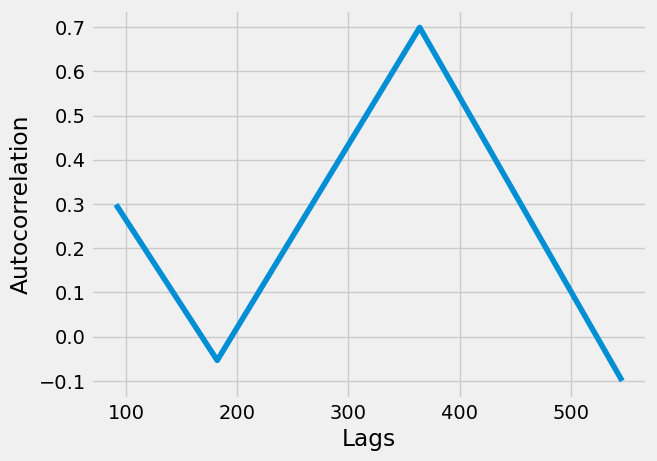

Best lag: 364


In [187]:
# Calculate autocorrelation for different lags
lags = [91, 182, 364, 546]
autocorr = [df.groupby(['store', 'item']).apply(lambda x: x['sales'].autocorr(lag=lag)).mean() for lag in lags]

# Visualize autocorrelation
plt.plot(lags, autocorr)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

# Identify the lag with the highest autocorrelation
best_lag = autocorr.index(max(autocorr))
print('Best lag:', lags[best_lag])

In [188]:
# Create lagged features
lag = 364
value = df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag))
df['sales_lag_364'] = value

# Define the range of window sizes to try
window_sizes = [182, 364, 546]

# Split the data into training and validation sets
train_size = int(len(df) * 0.8)
# Calculate the MAPE for each window size on the validation set
mape_scores = []
for window in window_sizes:
    train_set = df.iloc[:train_size,:]
    val_set = df.iloc[train_size:,:]
    rolling_mean_col = 'rolling_mean_{}'.format(window)
    train_set[rolling_mean_col] = train_set.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = window,
                                                                                                                   min_periods=10,
                                                                                                                   win_type="triang").mean())
    val_set[rolling_mean_col] = val_set.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).rolling(window = window,
                                                                                                                   min_periods=10,
                                                                                                                   win_type="triang").mean())
    train_set.dropna(inplace = True)
    val_set.dropna(inplace = True)
    mape = mean_absolute_percentage_error(val_set['sales'], val_set[rolling_mean_col])* 100
    mape_scores.append(mape)
    print('Val_set Window size {}: MAPE = {}'.format(window, mape))

    mape = mean_absolute_percentage_error(train_set['sales'], train_set[rolling_mean_col]) * 100
    print('Train_set Window size {}: MAPE = {}'.format(window, mape))

# Find the window size with the lowest MAPE
best_window_size = window_sizes[np.argmin(mape_scores)]
print('Best window size:', best_window_size)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Val_set Window size 182: MAPE = 27.874950078210574
Train_set Window size 182: MAPE = 11244145564113.207


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Val_set Window size 364: MAPE = 29.02869542411163
Train_set Window size 364: MAPE = 11838780947523.883


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Val_set Window size 546: MAPE = 24.60321777070639
Train_set Window size 546: MAPE = 10974698932634.969
Best window size: 546


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [189]:
# Transform data with skewed distribution into a more symmetrical distribution
df['sales_log'] = np.log1p(df["sales"].values)

# Define custom MAPE scorer for XGBoost
from sklearn.metrics import make_scorer

def xgb_mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred) * 100

mape_scorer = make_scorer(xgb_mape, greater_is_better=False)

In [190]:
def create_models():
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        n_estimators=100,
        random_state=42
    )

    lgb_model = lgb.LGBMRegressor(
        objective='regression',
        metric='rmse',
        n_estimators=100,
        random_state=42
    )

    cb_model = cb.CatBoostRegressor(
        loss_function='RMSE',
        eval_metric='RMSE',
        n_estimators=100,
        random_seed=42,
        verbose=False
    )

    return xgb_model, lgb_model, cb_model

# XGBoost hyperparameters 
best_params_xgb = {
    'max_depth': 10, #5
    'min_child_weight': 500,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'colsample_bylevel': 0.9,
    'eta': 0.2
}

# LightGBM hyperparameters
best_params_lgb = {
    'num_leaves': 50,
    'max_depth': 10, #8
    'min_child_samples': 40,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'learning_rate': 0.2
}

# CatBoost hyperparameters
best_params_cb = {
    'depth': 10, #6
    'min_child_samples': 10,
    'subsample': 0.9,
    'colsample_bylevel': 0.9,
    'learning_rate': 0.2
}

In [191]:
# Calculate the rolling mean of sales with a window size of 'best_window_size' and add it as a new column
value = df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(1).rolling(window=best_window_size, min_periods=10, win_type="triang").mean())
df['sales_roll_mean_' + str(best_window_size)] = value

In [192]:
# Define models and hyperparameters
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

def create_models():
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        n_estimators=100,
        random_state=42
    )

    lgb_model = lgb.LGBMRegressor(
        objective='regression',
        metric='rmse',
        n_estimators=100,
        random_state=42
    )

    cb_model = cb.CatBoostRegressor(
        loss_function='RMSE',
        eval_metric='RMSE',
        n_estimators=100,
        random_seed=42,
        verbose=False
    )

    return xgb_model, lgb_model, cb_model

# XGBoost hyperparameters 
best_params_xgb = {
    'max_depth': 10,
    'min_child_weight': 500,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'colsample_bylevel': 0.9,
    'eta': 0.2
}

# LightGBM hyperparameters
best_params_lgb = {
    'num_leaves': 50,
    'max_depth': 10,
    'min_child_samples': 40,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'learning_rate': 0.2
}

# CatBoost hyperparameters
best_params_cb = {
    'depth': 10,
    'min_child_samples': 10,
    'subsample': 0.9,
    'colsample_bylevel': 0.9,
    'learning_rate': 0.2
}

In [193]:
# Define the feature columns and the target column
features = ['store', 'item', 'dayofweek', 'dayofmonth', 'quarter', 'month', 'year', 'dayofyear', 'sales_lag_364', 'sales_roll_mean_546']
target = 'sales'

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Define the XGBoost model parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 10, #8
    'min_child_weight': 300,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'colsample_bylevel': 0.8,
    'eta': 0.2,
    'seed': 42
}


# Define the number of splits for time series cross-validation
n_splits = 5

# Perform time series cross-validation and train the model
tscv = TimeSeriesSplit(n_splits=n_splits)

from sklearn.model_selection import RandomizedSearchCV

xgb_model, lgb_model, cb_model = create_models()

# Number of random search iterations
n_iter = 50

X_train = train_data[features]
y_train = train_data[target]

In [194]:
# Update the models with the best hyperparameters found
xgb_model.set_params(**best_params_xgb)
lgb_model.set_params(**best_params_lgb)
cb_model.set_params(**best_params_cb)

# Define the number of splits for time series cross-validation
n_splits = 5

# Perform time series cross-validation and train the models
tscv = TimeSeriesSplit(n_splits=n_splits)
mape_scores = []

for train_index, test_index in tscv.split(train_data):
    X_train, X_test = train_data.iloc[train_index][features], train_data.iloc[test_index][features]
    y_train, y_test = train_data.iloc[train_index][target], train_data.iloc[test_index][target]

    # Train the models
    xgb_model.fit(X_train, y_train)
    lgb_model.fit(X_train, y_train)
    cb_model.fit(X_train, y_train)

    # Make predictions
    xgb_preds = xgb_model.predict(X_test)
    lgb_preds = lgb_model.predict(X_test)
    cb_preds = cb_model.predict(X_test)

    # Calculate MAPE for each model
    xgb_mape = mean_absolute_percentage_error(y_test, xgb_preds)* 100
    lgb_mape = mean_absolute_percentage_error(y_test, lgb_preds)* 100
    cb_mape = mean_absolute_percentage_error(y_test, cb_preds)* 100

    print(f"XGBoost MAPE: {xgb_mape}")
    print(f"LightGBM MAPE: {lgb_mape}")
    print(f"CatBoost MAPE: {cb_mape}")

    # Calculate the weights based on MAPE (lower MAPE gets higher weight)
    total_mape = xgb_mape + lgb_mape + cb_mape
    xgb_weight = (1 - xgb_mape / total_mape) / 2
    lgb_weight = (1 - lgb_mape / total_mape) / 2
    cb_weight = (1 - cb_mape / total_mape) / 2

    # Ensemble predictions using weighted averaging
    ensemble_preds = xgb_weight * xgb_preds + lgb_weight * lgb_preds + cb_weight * cb_preds

    # Calculate the ensemble MAPE
    ensemble_mape = mean_absolute_percentage_error(y_test, ensemble_preds)* 100
    print(f"Ensemble MAPE: {ensemble_mape}")
    mape_scores.append(ensemble_mape)

# Calculate the average MAPE across all folds
average_mape = sum(mape_scores) / len(mape_scores)
print(f"Average ensemble MAPE: {average_mape}")

XGBoost MAPE: 11.671098408143274
LightGBM MAPE: 11.81850645742127
CatBoost MAPE: 12.242936345726418
Ensemble MAPE: 11.745096695827254
XGBoost MAPE: 14.291562007415385
LightGBM MAPE: 14.39075161111468
CatBoost MAPE: 15.983311583027266
Ensemble MAPE: 14.49287305242267
XGBoost MAPE: 13.468764520860235
LightGBM MAPE: 13.34494752328485
CatBoost MAPE: 13.281000516674238
Ensemble MAPE: 13.26728634172341
XGBoost MAPE: 12.157368290893752
LightGBM MAPE: 12.340273022408125
CatBoost MAPE: 12.162080845667255
Ensemble MAPE: 12.06704966948265
XGBoost MAPE: 13.605039473093816
LightGBM MAPE: 13.617230028733951
CatBoost MAPE: 13.605586865130439
Ensemble MAPE: 13.454830741260245
Average ensemble MAPE: 13.005427300143248


In [195]:
# Load the test data
test_df = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/test.csv')

# Create a copy of the training data
train_data = df.copy()

# Load the test data again (if needed for further processing)
test_data = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/test.csv')

# Add the missing columns to the test data
test_data['date'] = pd.to_datetime(test_data['date'])
test_data['sales'] = np.nan

# Extract date-related features from the date column
test_data['dayofweek'] = test_data['date'].dt.dayofweek
test_data['dayofmonth'] = test_data['date'].dt.day
test_data['quarter'] = test_data['date'].dt.quarter
test_data['month'] = test_data['date'].dt.month
test_data['year'] = test_data['date'].dt.year
test_data['dayofyear'] = test_data['date'].dt.dayofyear

# Initialize lag and rolling mean columns with NaN values
test_data['sales_lag_364'] = np.nan
test_data['sales_roll_mean_546'] = np.nan

# Drop the 'id' column as it is not needed for modeling
test_data = test_data.drop('id', axis=1)

# Display the modified test data
test_data

,date,store,item,sales,dayofweek,dayofmonth,quarter,month,year,dayofyear,sales_lag_364,sales_roll_mean_546
0,2018-01-01,1,1,NaN,0,1,1,1,2018,1,NaN,NaN
1,2018-01-02,1,1,NaN,1,2,1,1,2018,2,NaN,NaN
2,2018-01-03,1,1,NaN,2,3,1,1,2018,3,NaN,NaN
3,2018-01-04,1,1,NaN,3,4,1,1,2018,4,NaN,NaN
4,2018-01-05,1,1,NaN,4,5,1,1,2018,5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,1,27,1,3,2018,86,NaN,NaN
44996,2018-03-28,10,50,NaN,2,28,1,3,2018,87,NaN,NaN
44997,2018-03-29,10,50,NaN,3,29,1,3,2018,88,NaN,NaN
44998,2018-03-30,10,50,NaN,4,30,1,3,2018,89,NaN,NaN


In [196]:
# Combine the training and test data into a single DataFrame for processing
new_df = pd.concat([train_data, test_data])

# Display the combined DataFrame
new_df

,date,store,item,sales,dayofweek,dayofmonth,quarter,month,year,dayofyear,sales_lag_364,sales_log,sales_roll_mean_546
0,2013-01-01,1,1,13.0,1,1,1,1,2013,1,NaN,2.639057,NaN
1,2013-01-02,1,1,11.0,2,2,1,1,2013,2,NaN,2.484907,NaN
2,2013-01-03,1,1,14.0,3,3,1,1,2013,3,NaN,2.708050,NaN
3,2013-01-04,1,1,13.0,4,4,1,1,2013,4,NaN,2.639057,NaN
4,2013-01-05,1,1,10.0,5,5,1,1,2013,5,NaN,2.397895,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,1,27,1,3,2018,86,NaN,NaN,NaN
44996,2018-03-28,10,50,NaN,2,28,1,3,2018,87,NaN,NaN,NaN
44997,2018-03-29,10,50,NaN,3,29,1,3,2018,88,NaN,NaN,NaN
44998,2018-03-30,10,50,NaN,4,30,1,3,2018,89,NaN,NaN,NaN


In [197]:
# Define lag and rolling window sizes
lag = 364
window = 546

# Create lagged feature 'sales_lag_364' grouped by store and item
new_df['sales_lag_364'] = new_df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag))

# Create rolling mean feature 'sales_roll_mean_546' grouped by store and item
new_df['sales_roll_mean_546'] = new_df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean())

In [198]:
# Filter out data from 'new_df' for dates starting from 2018
test_df = new_df.loc[(new_df['date']>='2018')]

# Define the features used for prediction
features = ['store', 'item', 'dayofweek', 'dayofmonth', 'quarter' ,'month', 'year', 'dayofyear', 'sales_lag_364', 'sales_roll_mean_546']

# Make predictions on the test data
xgb_preds = xgb_model.predict(test_df[features])
lgb_preds = lgb_model.predict(test_df[features])
cb_preds = cb_model.predict(test_df[features])


# Ensemble predictions using weighted averaging
new_ensemble_preds = xgb_weight * xgb_preds + lgb_weight * lgb_preds + cb_weight * cb_preds

# Save the ensemble predictions to the new test dataframe
test_df['sales'] = new_ensemble_preds

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [200]:
# Reset index to ensure the submission index starts from 0
test_df = test_df.reset_index(drop=True)

# Prepare submission dataframe with predicted sales
submission = pd.DataFrame(test_df['sales'], columns=['sales'])
#submission = submission.round() #Round Nearest
#submission = submission.apply(np.ceil) #Round Up
submission = submission.apply(np.floor) #Round Down
submission.to_csv('submission.csv', index_label = 'id')
submission

,sales
0,12.0
1,14.0
2,14.0
3,15.0
4,16.0
...,...
44995,72.0
44996,73.0
44997,77.0
44998,84.0
